# This file is meant as a demonstration to load in the output from the IPSL TipESM runs.

It is meant to show/do the following:
* how to load in useful general (and custom made) packages
* retrieve the data specifics and filenames for the respective TipESM model runs
* How to look at the (meta)data (without loading all of it in) using xarray
* Which time range the simulations cover and what they look like
* How to calculate regional (global) averages and plot them as time series
* How to plot maps of time slices or a temporal mean on the model's native grid and in a regridded form
* How to use map projections for plotting

author: Eike E. Köhn
date: Mar 28, 2025

## Import packages

In [1]:
# Import generally useful/necessary packages
import numpy as np    # math and array calculations
import xarray as xr   # powerful tool to treat multidimensional netcdf data
import cftime         # handling time formats
import nc_time_axis   # handling time formats
import xesmf as xe    # handy tools for regridding geospatial data

import os             # operating system interface
import sys            # OS specific tools
import re             # regular expressions
import glob           # Unix style pathname pattern expansion¶

import matplotlib.pyplot as plt # plotting tool
import matplotlib.cm as cm
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cmocean as cmo  # colormaps for plotting

import cartopy
import cartopy.crs as ccrs # for nice map projections

from cdo import Cdo   # use CDO (Climate Data Operator) tools within python

# other useful packages (with their common import abbreviations) are: scipy (sp), pandas (pd)

# Import custom made modules
sys.path.append('./modules')
import calc_remap as Remapper
import set_params as Params
import get_modeldata as ModelGetter
import get_regional_masks as MaskGetter

from importlib import reload
reload(Remapper)

<module 'calc_remap' from '/home/ekoehn/jobs/jupyter/TipESM/TipESM_simulations/./modules/calc_remap.py'>

## Define run specifics (including the file paths, area masks and a color id) and save them in an rparam object
The individual rparam instances are kept together in a rparams dictionary, with the run names as dictionary keys. 
By running "ModelGetter.get_modelfiles" and "ModelGetter.get_areaweights" we add the grid cell area fields of all available files to each rparam object.


In [2]:
# Set the variable, frequency, domain, and grid of the model outputs that you want to analyze
var = 'o2os'    # 'intpp' for vertically integrated net primary productivity
frequency='mon'  # 'mon' for 'monthly
domain = 'O'     # 'O' for ocean
grid = 'gn'      # the irregular native model grid 

# Get the parameters for the IPSL simulations organized as a dictionary
rparams = Params.get_IPSL_simulation_set(var,domain,grid,frequency)

# get the filenames for the different runs and add them to the rparam objects
for key in rparams.keys():
    rparams[key] = ModelGetter.get_modelfiles(rparams[key])

# get the grid cell area info for weighting purposes
for key in rparams.keys():
    rparams[key] = ModelGetter.get_areaweights(rparams[key])


## Some explications for the rparams dictionary

In [3]:
# retrieve the info about the contents of rparams
list_of_available_keys = list(rparams.keys())
example_key = list_of_available_keys[0]

print('The following keys/runs are available in the IPSL set of simulations for the given variable: ')
print(list_of_available_keys)
print(' ')
print(f'For example, for the run {example_key} we have the following attributes in each rparam instance:')
print([x for x in dir(rparams[example_key]) if not x.startswith('__')]) 
print(' ')
print('You can look for example at the filenames for a given simulation by executing:')
print(rparams[example_key].filenames)


The following keys/runs are available in the IPSL set of simulations for the given variable: 
['esm_hist_r1', 'esm_hist_r2', 'esm_hist_r3', 'esm_hist_r4', 'esm_pic_r1', 'esm_rampup', 'esm_stab_1p5', 'esm_stab_2p0', 'esm_stab_3p0', 'esm_stab_4p0']
 
For example, for the run esm_hist_r1 we have the following attributes in each rparam instance:
['area', 'areacello', 'domain', 'experiment', 'filenames', 'frequency', 'grid', 'id_color', 'institute', 'member', 'mip', 'model', 'variable']
 
You can look for example at the filenames for a given simulation by executing:
['/thredds/tgcc/store/torreso/CMIP6Plus/CMIP/IPSL/IPSL-CM6-ESMCO2/esm-hist/r1i1p3f1/Omon/o2os/gn/v20250318/o2os_Omon_IPSL-CM6-ESMCO2_esm-hist_r1i1p3f1_gn_185001-194912.nc', '/thredds/tgcc/store/torreso/CMIP6Plus/CMIP/IPSL/IPSL-CM6-ESMCO2/esm-hist/r1i1p3f1/Omon/o2os/gn/v20250318/o2os_Omon_IPSL-CM6-ESMCO2_esm-hist_r1i1p3f1_gn_195001-201412.nc']


## Plot the grid cell area of the native model grid

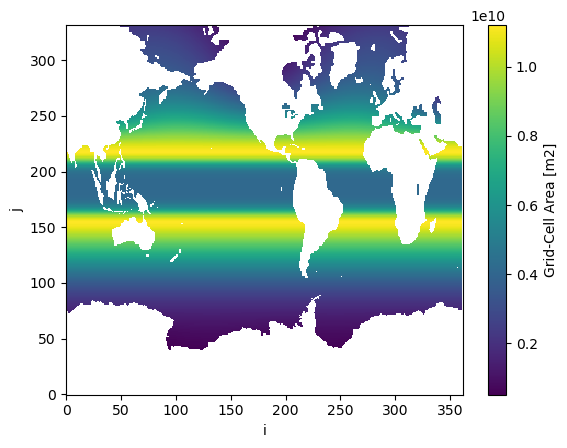

In [4]:
rparams[example_key].areacello.plot()

## Open the datasets and plot the time ranges of the individual simulations
Note that the datasets are not yet loaded into memory (only the time axis is loaded since we plot it).

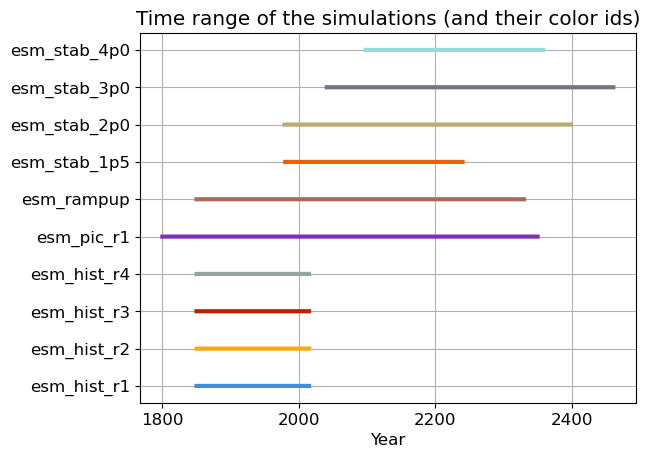

In [5]:
fontsize=12
plt.rcParams['font.size']=fontsize
fig, ax = plt.subplots()
for kdx,key in enumerate(rparams.keys()):
    ds = xr.open_mfdataset(rparams[key].filenames, use_cftime=True)
    yvec = np.zeros(ds.time.size)+kdx
    ax.plot(ds.time,yvec,linewidth=3,color=rparams[key].id_color)
ax.set_yticks(np.arange(len(rparams.keys())))
ax.set_yticklabels([key for key in rparams.keys()])
#plt.legend()
ax.set_xlabel('Year')
ax.grid()
ax.set_title('Time range of the simulations (and their color ids)')
plt.show()

## Make a global mean time series plot for the simulations (this takes a long time right now, since it has to process quite a lot of monthly data)
Solutions to making it faster would be:
* use annual mean data instead of monthly data (omit the monthly time series)
* use a rechunked version of the monthly data
* get rid of the loop by parallelizing the treatment of the individual models

For more flexibility in the plotting, rewrite to do the computation of all timeseries first and then do the plotting (since the plotting itself is very fast). 


esm_hist_r1
esm_hist_r2
esm_hist_r3
esm_hist_r4
esm_pic_r1
esm_rampup
esm_stab_1p5
esm_stab_2p0
esm_stab_3p0
esm_stab_4p0


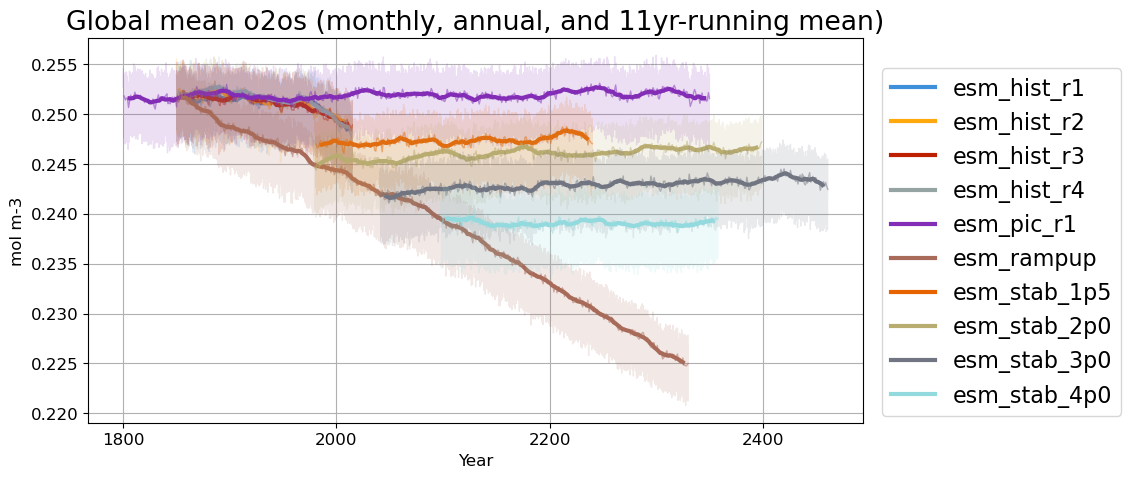

In [6]:
# initialize a figure
fig, ax = plt.subplots(figsize=(10,5))
fontsize=16
plt.rcParams['font.size']=fontsize

# loop over simulations, calculate the global mean and include it as a monthly, annual and smoothed annual time series
for kdx,key in enumerate(rparams.keys()): 
    print(key)
    ds = xr.open_mfdataset(rparams[key].filenames,use_cftime=True)
    #timevec = ds.time

    #get the area weights 
    weights = rparams[key].areacello.fillna(0) # fill in the land with a weight of 0
    
    # Calculuate the spatial mean 
    datavec_monthly = ds[rparams[key].variable].weighted(weights).mean(dim=("i","j")).compute() # calculate the area weighted mean (note that by running .compute(), that data is finally loaded into memory, which makes it slow)

    # plot the monthly raw data
    plt.plot(datavec_monthly.time,datavec_monthly,linewidth=1,color=rparams[key].id_color,alpha=0.15) 

    # Plot annual mean data, by aggregating 12 months to a year
    datavec_annual = datavec_monthly.resample(time='1YE').mean()
    plt.plot(datavec_annual.time,datavec_annual,linewidth=1,color=rparams[key].id_color,alpha=0.5)  

    # Plot a smoothed version of the annual data, by calculating a moving average 
    running_window = 11 # 11 years 
    datavec_smoothed = datavec_annual.rolling(time=running_window, center=True).mean()
    plt.plot(datavec_smoothed.time,datavec_smoothed,linewidth=3,color=rparams[key].id_color,label=key)  
    
ax.set_xlabel('Year')
ax.grid()
ax.legend(loc=2,bbox_to_anchor=(1.01,0.95))
ax.set_ylabel(f'{ds[rparams[key].variable].units}')
ax.set_title(f'Global mean {rparams[key].variable} (monthly, annual, and {running_window}yr-running mean)')
plt.show()

## Calculate the time mean for a chosen variable

In [7]:
# choose a run
rparam_choice = rparams[example_key] 
# open the dataset
ds = xr.open_mfdataset(rparam_choice.filenames,use_cftime=True)
# calculate the temporal mean
mean_var = ds[rparam_choice.variable].mean(dim='time')

## Plot the data on the native grid using xarray's implemented plotting routine

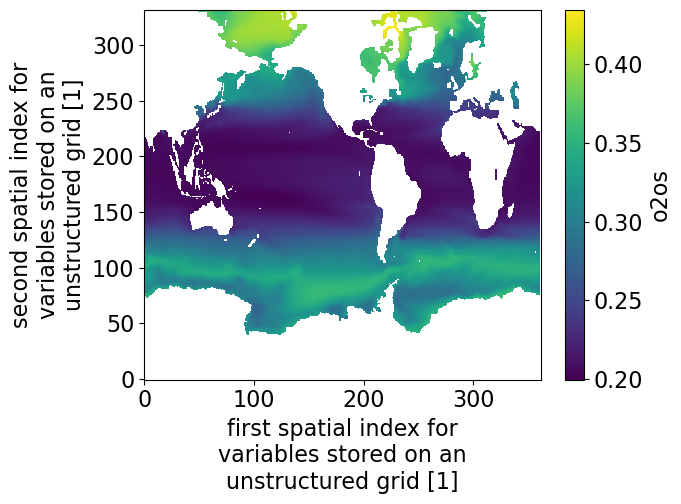

In [8]:
fig, ax = plt.subplots()
mean_var.plot()
plt.show()

## Regrid the data onto a 1°x1° grid using cdo's fast remapdis. Creates temporary netcdfs for this, which are deleted again afterwards

In [9]:
mean_var_gr = Remapper.cdo_remapdis(mean_var) # uses the imported cdo_remapdis function, which calls "cdo remapdis,r360x180 ifile ofile"

## Plot a map of the regridded data using manual plotting (instead of xarray's implemented plotting routine)

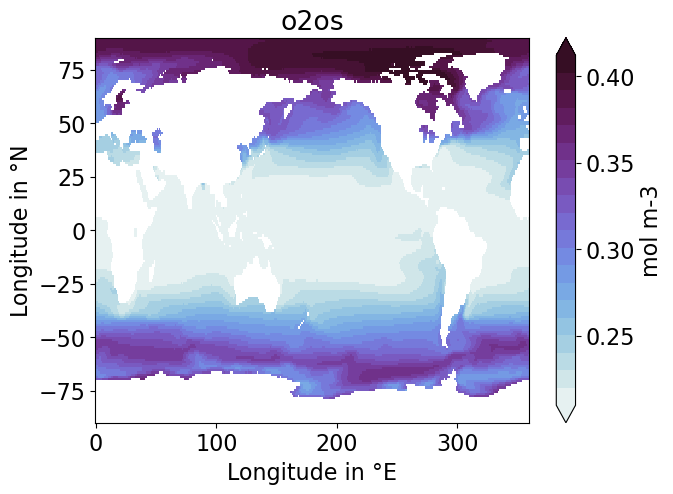

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
vmax = mean_var_gr[rparam_choice.variable].max()*0.95
vmin = mean_var_gr[rparam_choice.variable].min()*1.05
ncolors = 20
cmap = plt.get_cmap('cmo.dense',ncolors)
c0 = ax.pcolormesh(mean_var_gr.lon,mean_var_gr.lat,mean_var_gr[rparam_choice.variable],vmin=vmin,vmax=vmax,cmap=cmap)
ax.set_xlabel('Longitude in °E')
ax.set_ylabel('Longitude in °N')
ax.set_title(f'{rparam_choice.variable}')
plt.colorbar(c0,label=ds[rparam_choice.variable].units,extend='both')

## Plot the same map using a cartopy projection

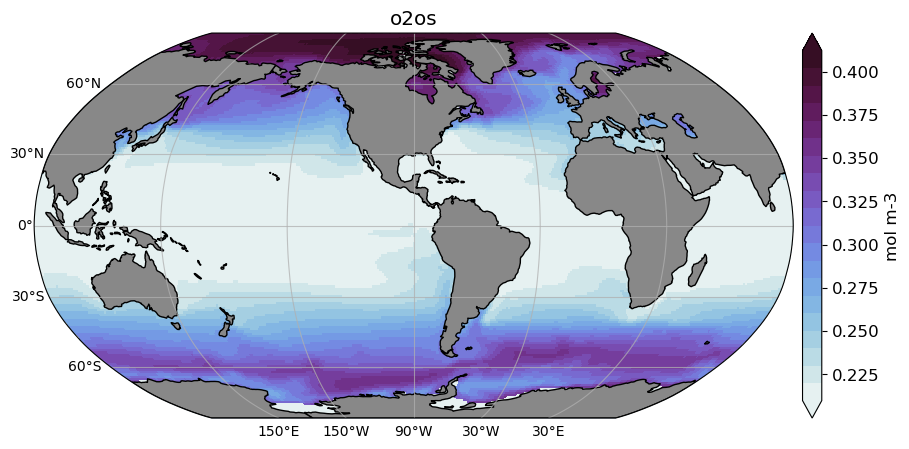

In [11]:
fig = plt.figure(figsize=(12,5))
fontsize=12
plt.rcParams['font.size']=fontsize
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-90))
vmax = mean_var_gr[rparam_choice.variable].max()*0.95
vmin = mean_var_gr[rparam_choice.variable].min()*1.05
ncolors = 20
cmap = plt.get_cmap('cmo.dense',ncolors)
c0 = ax.pcolormesh(mean_var_gr.lon,mean_var_gr.lat,mean_var_gr[rparam_choice.variable],vmin=vmin,vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())

# add some aspects to make it look nicer
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black',facecolor='#888888')
ax.set_global()
ax.set_title(f'{rparam_choice.variable}')
plt.colorbar(c0,label=ds[rparam_choice.variable].units,pad=.01,extend='both')
gls = ax.gridlines(alpha=0.75,ylocs=np.arange(-90, 91, 30),draw_labels=True, xlocs=[-150,-90,-30,30,150])
gls.top_labels=False
gls.xlabel_style = {'size': fontsize-2}
gls.ylabel_style = {'size': fontsize-2}

## Make a regional average time series plot, by applying a regional mask

## First, get some masks - here we use masks from the RECCAP2 project (https://reccap2-ocean.github.io)

In [12]:
region_dict, region_lookup_dict = MaskGetter.set_regions(source='RECCAP2')

## Plot the subpolar North Atlantic mask (contains the subpolar gyre and Nordic Seas)

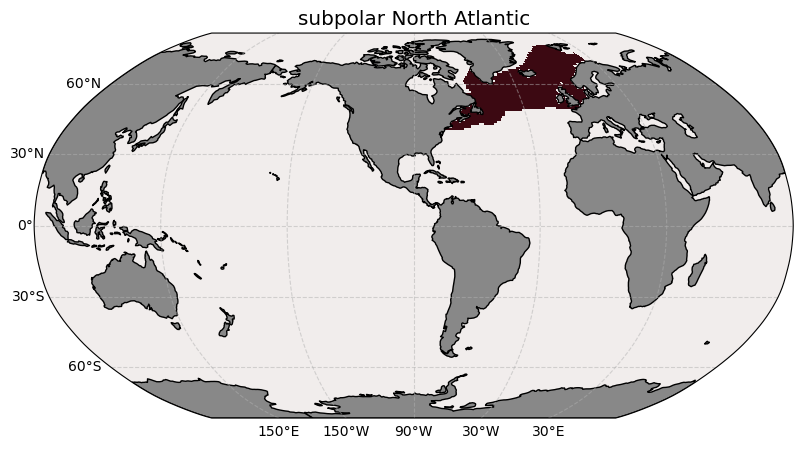

In [13]:
chosen_region = 'atlantic1'
chosen_mask = region_dict[chosen_region]

fig = plt.figure(figsize=(12,5))
fontsize=12
plt.rcParams['font.size']=fontsize
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=-90))
colormap = plt.get_cmap('cmo.amp',2)
c0 = ax.pcolormesh(chosen_mask.lon,chosen_mask.lat,chosen_mask,vmin=0,vmax=1e-6,cmap=colormap,transform=ccrs.PlateCarree())
# add some aspects to make it look nicer
ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black',facecolor='#888888')
ax.set_global()
ax.set_title(f"{region_lookup_dict[chosen_region]}")
gls = ax.gridlines(linestyle='--',alpha=0.5,ylocs=np.arange(-90, 91, 30),draw_labels=True, xlocs=[-150,-90,-30,30,150])
gls.top_labels=False
gls.xlabel_style = {'size': fontsize-2}
gls.ylabel_style = {'size': fontsize-2}

## Use this mask to do a regional average over multiple time steps

Note that the mask of the region is on a different grid (1°x1°) than the model output on the native grid. Hence, we regrid the mask onto the native model grid.
Another option would be to regrid the model output onto the mask grid. But this is computationally more expensive, since we would need to regrid every time step.

In [14]:
regridder = xe.Regridder(chosen_mask, mean_var, method="nearest_s2d")
mask_gn = regridder(chosen_mask)

## Plot the regional mask

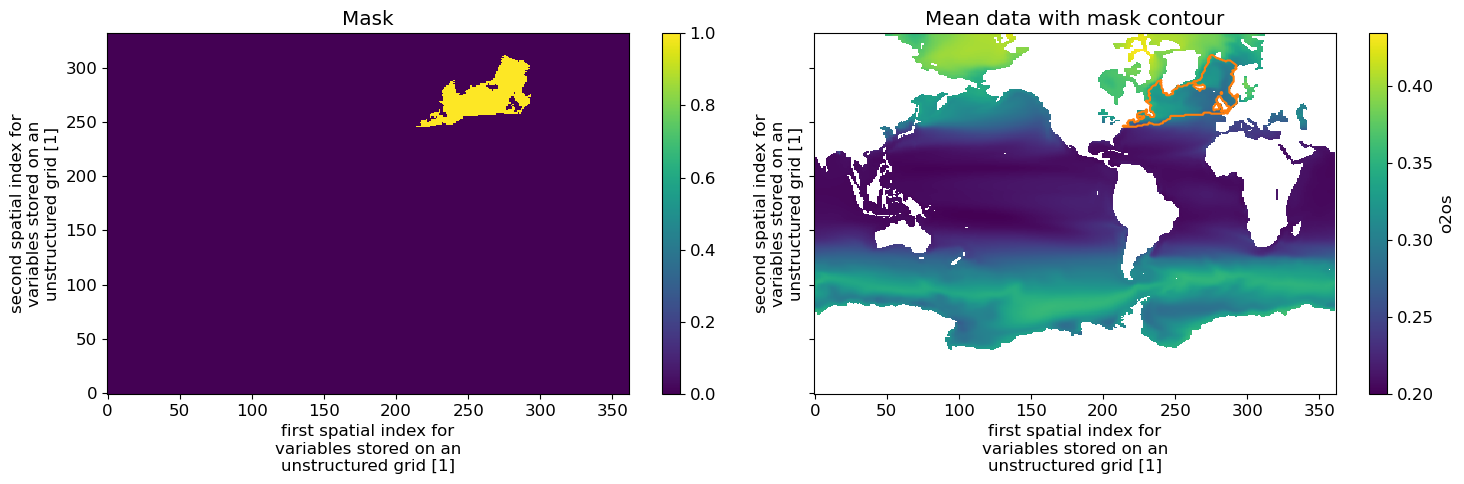

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
mask_gn.plot(ax=ax[0])
ax[0].set_title('Mask')
mean_var.plot(ax=ax[1])
ax[1].set_title('Mean data with mask contour')
ax[1].contour(mask_gn,levels=[0.5],colors='C1')
plt.tight_layout()
plt.show()

## Now apply this mask and calculate the spatial averages to produce a timeseries

esm_hist_r1
esm_hist_r2
esm_hist_r3
esm_hist_r4
esm_pic_r1
esm_rampup
esm_stab_1p5
esm_stab_2p0
esm_stab_3p0
esm_stab_4p0


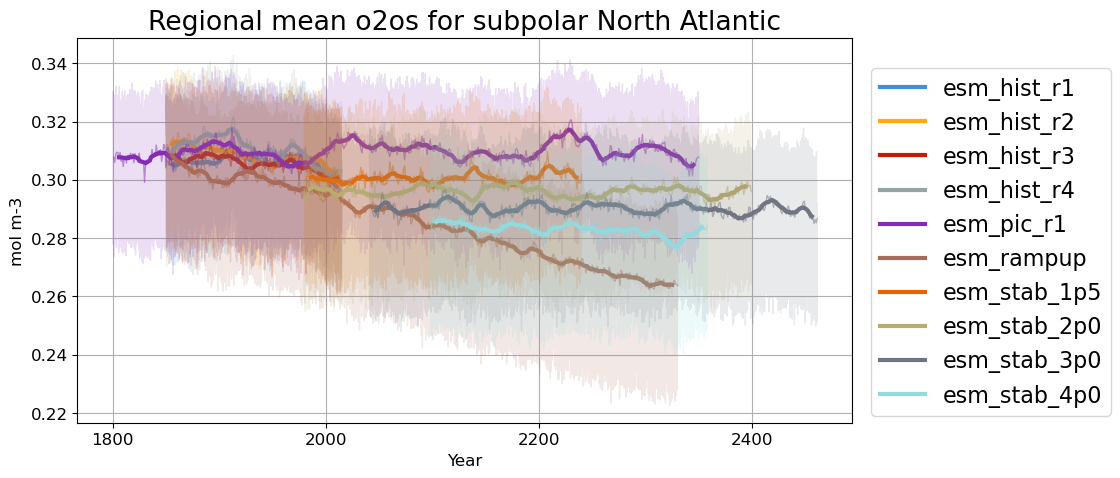

In [16]:
# initialize a figure
fig, ax = plt.subplots(figsize=(10,5))
fontsize=16
plt.rcParams['font.size']=fontsize

# loop over simulations, calculate the global mean and include it as a monthly, annual and smoothed annual time series
for kdx,key in enumerate(rparams.keys()): 
    print(key)
    ds = xr.open_mfdataset(rparams[key].filenames,use_cftime=True)
    #timevec = ds.time

    #get the area weights 
    weights = rparams[key].areacello.fillna(0) # fill in the land with a weight of 0
    
    # Calculuate the spatial mean 
    datavec_monthly = ds[rparams[key].variable].where(mask_gn).weighted(weights).mean(dim=("i","j")).compute() # calculate the area weighted mean (note that by running .compute(), that data is finally loaded into memory, which makes it slow)

    # plot the monthly raw data
    plt.plot(datavec_monthly.time,datavec_monthly,linewidth=1,color=rparams[key].id_color,alpha=0.15) 

    # Plot annual mean data, by aggregating 12 months to a year
    datavec_annual = datavec_monthly.resample(time='1YE').mean()
    plt.plot(datavec_annual.time,datavec_annual,linewidth=1,color=rparams[key].id_color,alpha=0.5)  

    # Plot a smoothed version of the annual data, by calculating a moving average 
    running_window = 11 # 11 years 
    datavec_smoothed = datavec_annual.rolling(time=running_window, center=True).mean()
    plt.plot(datavec_smoothed.time,datavec_smoothed,linewidth=3,color=rparams[key].id_color,label=key)  
    
ax.set_xlabel('Year')
ax.grid()
ax.legend(loc=2,bbox_to_anchor=(1.01,0.95))
ax.set_ylabel(f'{ds[rparams[key].variable].units}')
ax.set_title(f'Regional mean {rparams[key].variable} for {region_lookup_dict[chosen_region]}')
plt.show()

## List of all available subregions

In [17]:
region_lookup_dict

{'arctic1': 'central Arctic',
 'arctic2': 'East Greenland',
 'arctic3': 'Baffin Bay',
 'arctic4': 'Canadian Archipelago',
 'arctic5': 'Canadian North Coast',
 'arctic6': 'Chukchi Sea',
 'arctic7': 'East Siberian Sea',
 'arctic8': 'Laptev Sea',
 'arctic9': 'Kara Sea',
 'arctic10': 'Barents Sea',
 'atlantic1': 'subpolar North Atlantic',
 'atlantic2': 'intergyre North Atlantic',
 'atlantic3': 'subtropical North Atlantic',
 'atlantic4': 'tropical Atlantic',
 'atlantic5': 'subtropical South Atlantic',
 'atlantic6': 'Mediterranean Sea',
 'pacific1': 'subpolar North Pacific',
 'pacific2': 'intergyre North Pacific',
 'pacific3': 'subtropical North Pacific',
 'pacific4': 'western tropical Pacific',
 'pacific5': 'eastern tropical Pacific',
 'pacific6': 'subtropical South Pacific',
 'indian1': 'Arabian Sea',
 'indian2': 'Bay of Bengal',
 'indian3': 'tropical Indian Ocean',
 'indian4': 'subtropical South Indian Ocean',
 'southern1': 'Subantarctic Zone',
 'southern2': 'Polar Front Zone',
 'southern